In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline



## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



horse truck truck bird 


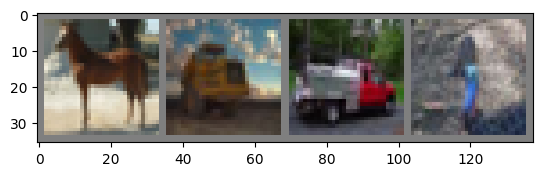

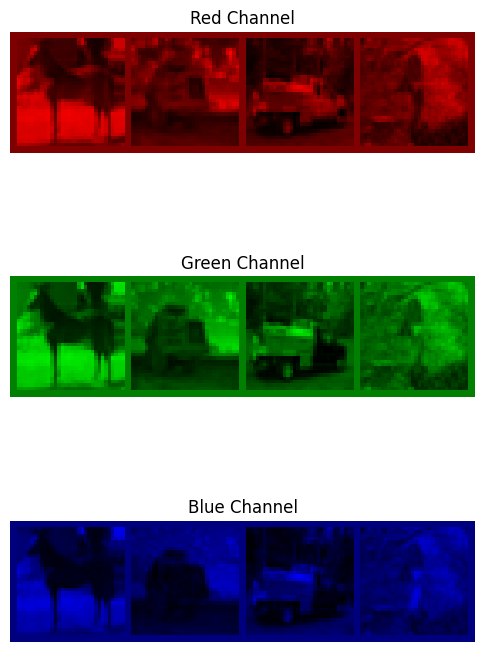

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def channelshow(img):
    # Function to show the pixels of each channel in its original color
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()

    # Create separate images for each channel
    red_img = np.zeros_like(npimg)
    green_img = np.zeros_like(npimg)
    blue_img = np.zeros_like(npimg)

    red_img[0] = npimg[0]  # Red channel
    green_img[1] = npimg[1]  # Green channel
    blue_img[2] = npimg[2]  # Blue channel

    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    axs[0].imshow(np.transpose(red_img, (1, 2, 0)))
    axs[0].axis('off')
    axs[0].set_title("Red Channel")

    axs[1].imshow(np.transpose(green_img, (1, 2, 0)))
    axs[1].axis('off')
    axs[1].set_title("Green Channel")

    axs[2].imshow(np.transpose(blue_img, (1, 2, 0)))
    axs[2].axis('off')
    axs[2].set_title("Blue Channel")

    plt.show()

    

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels

channelshow(torchvision.utils.make_grid(images))

# You can also specify a particular channel like 'red', 'green', or 'blue'


### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.229
[1,  4000] loss: 1.927
[1,  6000] loss: 1.700
[1,  8000] loss: 1.597
[1, 10000] loss: 1.521
[1, 12000] loss: 1.480
[2,  2000] loss: 1.422
[2,  4000] loss: 1.373
[2,  6000] loss: 1.331
[2,  8000] loss: 1.333
[2, 10000] loss: 1.306
[2, 12000] loss: 1.287
Finished Training


Let's quickly save our trained model:



In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



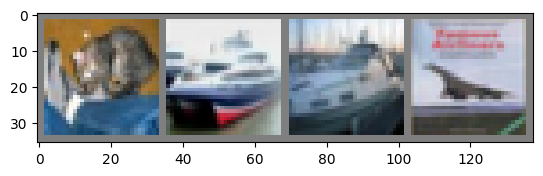

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [11]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  bird  car   ship  ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [71]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.




## We can explore even fancier technologies
* [Text-to-Image Generation Demo](https://huggingface.co/spaces/stabilityai/stable-diffusion)
* [Text-to-Video Generation](https://github.com/Stability-AI/generative-models)

## References

* [Deep Learning with Pytorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)


## Additional Materials:
* [Book: Dive into Deep Learning](https://d2l.ai/)
* [Stanford CS229: Machine Learning](https://www.youtube.com/playlist?list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU)
* [Stanford Lecture Collection: Convolutional Neural Networks for Visual Recognition](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv)